## BERT-классификатор

В качестве модели для дообучения будем использовать русскоязычную BERT-модель rubert-tiny2

In [ ]:
TF_BERT_MODEL_NAME = "cointegrated/rubert-tiny2"

In [ ]:
from huggingface_hub import login
from google.colab import userdata

login(userdata.get("HF_TOKEN"))

In [ ]:
# для воспроизводимости результатов
SEED = 42

### Импорты

In [ ]:
!pip install -q imblearn

In [ ]:
import numpy as np
import pandas as pd
import re
import string
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from transformers import BertTokenizerFast
from transformers import TFBertModel
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

### Загрузим и подготовим данные

Используем датасет с произведениями русских писателей

In [ ]:
data_path = keras.utils.get_file(
    "russian_literature.zip",
    "https://storage.yandexcloud.net/academy.ai/russian_literature.zip"
)

21547079/21547079 [==============================] - 2s 0us/step


In [ ]:
!unzip -qo "{data_path}" -d ./dataset

error:  cannot create ./dataset/poems/Blok/╨б╤В╨╕╤Е╨╛╤В╨▓╨╛╤А╨╡╨╜╨╕╤П 1897-1903 ╨│╨│, ╨╜╨╡ ╨▓╨╛╤И╨╡╨┤╤И╨╕╨╡ ╨▓ ╨╛╤Б╨╜╨╛╨▓╨╜╨╛╨╡ ╤Б╨╛╨▒╤А╨░╨╜╨╕╨╡.txt
        File name too long
error:  cannot create ./dataset/prose/Gogol/╨Я╨╛╨▓╨╡╤Б╤В╤М ╨╛ ╤В╨╛╨╝, ╨║╨░╨║ ╨┐╨╛╤Б╤Б╨╛╤А╨╕╨╗╤Б╤П ╨Ш╨▓╨░╨╜ ╨Ш╨▓╨░╨╜╨╛╨▓╨╕╤З ╤Б ╨Ш╨▓╨░╨╜╨╛╨╝ ╨Э╨╕╨║╨╕╤Д╨╛╤А╨╛╨▓╨╕╤З╨╡╨╝.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Ф╨╛╨║╨╗╨░╨┤, ╨┐╤А╨╕╨│╨╛╤В╨╛╨▓╨╗╨╡╨╜╨╜╤Л╨╣ ╨┤╨╗╤П ╨║╨╛╨╜╨│╤А╨╡╤Б╤Б╨░ ╨╛ ╨╝╨╕╤А╨╡ ╨▓ ╨б╤В╨╛╨║╨│╨╛╨╗╤М╨╝╨╡.txt
        File name too long
error:  cannot create ./dataset/publicism/Tolstoy/╨Я╨╛╤З╨╡╨╝╤Г ╤Е╤А╨╕╤Б╤В╨╕╨░╨╜╤Б╨║╨╕╨╡ ╨╜╨░╤А╨╛╨┤╤Л ╨▓╨╛╨╛╨▒╤Й╨╡ ╨╕ ╨▓ ╨╛╤Б╨╛╨▒╨╡╨╜╨╜╨╛╤Б╤В╨╕ ╤А╤Г╤Б╤Б╨║╨╕╨╣ ╨╜╨░╤Е╨╛╨┤╤П╤В╤Б╤П ╤В╨╡╨┐╨╡╤А╤М ╨▓ ╨▒╨╡╨┤╤Б╤В╨▓╨╡╨╜╨╜╨╛╨╝ ╨┐╨╛╨╗╨╛╨╢╨╡╨╜╨╕╨╕.txt
        File name too long


In [ ]:
# Возьмем 5 писателей с наибольшим количеством данных
CLASS_LIST = ["Dostoevsky", "Tolstoy", "Gorky", "Bryusov", "Turgenev"]

In [ ]:
import glob


all_texts = {}

for author in CLASS_LIST:
    all_texts[author] = ''
    prose_paths = glob.glob('./dataset/prose/{}/*.txt'.format(author))
    poems_paths = glob.glob('./dataset/poems/{}/*.txt'.format(author))
    paths = prose_paths + poems_paths
    for path in paths:
        with open(f'{path}', 'r', errors='ignore') as f:
            text = f.read()
        all_texts[author] += ' ' + text.replace('\n', ' ')


In [ ]:
lengths = [len(all_texts[author]) for author in all_texts]
print(lengths)

[11221679, 9392435, 4324025, 2830897, 2345243]


In [ ]:
# обрежем тексты по среднему значению длины текстов для большей сбалансированности
# датасета и отсутствию множественного дублирования текстов с малым количеством
# примеров после балансировки RandomOverSampler
for author in all_texts:
    all_texts[author] = all_texts[author][:lengths[2]]

#### Разобьем тексты на отрывки и создадим DataFrame

In [ ]:
NUM_WORDS = 40


text = []
author = []


for key in all_texts:
    temp_list = []
    for word in all_texts[key].split():
        temp_list.append(word)
        if len(temp_list) == NUM_WORDS:
            text.append(' '.join(temp_list))
            author.append(key)
            temp_list = []

df = pd.DataFrame()
df['author'] = author
df['text'] = text


In [ ]:
df

,author,text
0,Dostoevsky,Федор Михайлович Достоевский Чужая жена и муж ...
1,Dostoevsky,"вечера, среди улицы. А уж известно, что если о..."
2,Dostoevsky,"– говорил господин в енотах, – но я… я, право,..."
3,Dostoevsky,"лицо было довольно бледненько, голос его дрожа..."
4,Dostoevsky,"обратиться к кому-нибудь с просьбой. Да и, нак..."
...,...,...
72049,Turgenev,"одиночество бессемейного бобыля, доживаю я ску..."
72050,Turgenev,"та рука, которую мне только раз пришлось прижа..."
72051,Turgenev,и стремлений? Так легкое испарение ничтожной т...
72052,Turgenev,"музеев Дрездена, где хранится ценная коллекция..."


#### Очистка текстов

In [ ]:

def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    banned_list= string.punctuation + 'Ã' + '±' + 'ã' + '¼' + 'â' + '«' + '»' + '§' + '–'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text


def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)


In [ ]:
texts_new = []
for t in df.text:
    texts_new.append(remove_mult_spaces(filter_chars(strip_all_entities(t))))
df['text_clean'] = texts_new

### Токенизация

In [ ]:
TOKENIZER = BertTokenizerFast.from_pretrained(TF_BERT_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.74M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

#### Оценим максимальную и среднюю длины токенизированных последовательностей

In [ ]:
token_lens = []

for txt in df['text_clean'].values:
    tokens = TOKENIZER.encode(txt, max_length=5000, truncation=True)
    token_lens.append(len(tokens))

max_len = np.max(token_lens)
mean_len = np.mean(token_lens)

In [ ]:
print('Максимальная длина токенов:', max_len)
print('Средняя длина токенов:', mean_len)

Максимальная длина токенов: 105
Средняя длина токенов: 52.326394093318896


### Соотношение классов

In [ ]:
df['author'].value_counts()

,count
author,
Gorky,17500
Dostoevsky,17135
Tolstoy,17076
Bryusov,10883
Turgenev,9460


#### Балансируем соотношение классов

In [ ]:
ros = RandomOverSampler()

train_x, train_y = ros.fit_resample(
    np.array(df['text_clean']).reshape(-1, 1),
    np.array(df['author']).reshape(-1, 1)
)

train_os = pd.DataFrame(
    list(zip([x[0] for x in train_x], train_y)),
    columns=['text_clean', 'author']
)

In [ ]:
train_os['author'].value_counts()

,count
author,
Dostoevsky,17500
Tolstoy,17500
Gorky,17500
Bryusov,17500
Turgenev,17500


### Формируем выборки

In [ ]:
X = train_os['text_clean'].values
y = train_os['author'].values

#### Разделим на тренировочную, проверочную и тестовую выборки

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

In [ ]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED
)

#### Применим OneHotEncoder

In [ ]:
ohe = preprocessing.OneHotEncoder()

y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [ ]:
print(f"Тренировочная выборка: {X_train.shape[0]}")
print(f"Проверочная выборка: {X_val.shape[0]}")
print(f"Тестовая выборка: {X_test.shape[0]}")

Тренировочная выборка: 70000
Проверочная выборка: 8750
Тестовая выборка: 8750


#### Токенизируем входные данные

In [ ]:
def tokenize(data, tokenizer=TOKENIZER, max_len=128):
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)


In [ ]:
train_input_ids, train_attention_masks = tokenize(X_train)
val_input_ids, val_attention_masks = tokenize(X_val)
test_input_ids, test_attention_masks = tokenize(X_test)

Удалим лишние сущности, чтоб не перегружать ОЗУ

In [ ]:
list_for_del = [
    X, y,
    X_temp, y_temp,
    X_train,
    X_val,
    X_test,
    df, train_os,
    all_texts,
    text, texts_new,
    author,
]
for obj in list_for_del:
    del obj


### Модель

In [ ]:
bert_model = TFBertModel.from_pretrained(TF_BERT_MODEL_NAME)

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/118M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already u

In [ ]:
def create_classification_bert_model(bert_model, max_len=128, classes_num=2):
    # Параметры обучения
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    # вход для токенизированной последовательности
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    # маска
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')
    # BERT-модель
    embeddings = bert_model([input_ids, attention_masks])[1]

    output = tf.keras.layers.Dense(
        classes_num,
        activation="softmax"
    )(embeddings)
    model = tf.keras.models.Model(
        inputs=[
            input_ids,
            attention_masks
        ],
        outputs = output
    )
    model.compile(opt, loss=loss, metrics=accuracy)

    return model


In [ ]:
model = create_classification_bert_model(
    bert_model,
    classes_num=len(CLASS_LIST),
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 128)]                0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   2919376   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   8          'input_2[0][0]']             
                             hidden_state=(None, 128, 3                                           
                             12),                                                             

### Обучение модели

In [ ]:
EPOCHS = 10
BATCH_SIZE = 64


history = model.fit(
    [
        train_input_ids,
        train_attention_masks
    ],
    y_train,
    validation_data=(
        [
            val_input_ids,
            val_attention_masks
        ],
        y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/10
1094/1094 [==============================] - 152s 129ms/step - loss: 0.9703 - categorical_accuracy: 0.6315 - val_loss: 0.6237 - val_categorical_accuracy: 0.7711
Epoch 2/10
1094/1094 [==============================] - 141s 129ms/step - loss: 0.5583 - categorical_accuracy: 0.7993 - val_loss: 0.4680 - val_categorical_accuracy: 0.8305
Epoch 3/10
1094/1094 [==============================] - 143s 131ms/step - loss: 0.4166 - categorical_accuracy: 0.8520 - val_loss: 0.3925 - val_categorical_accuracy: 0.8595
Epoch 4/10
1094/1094 [==============================] - 137s 126ms/step - loss: 0.3259 - categorical_accuracy: 0.8856 - val_loss: 0.3434 - val_categorical_accuracy: 0.8761
Epoch 5/10
1094/1094 [==============================] - 142s 130ms/step - loss: 0.2582 - categorical_accuracy: 0.9109 - val_loss: 0.3109 - val_categorical_accuracy: 0.8951
Epoch 6/10
1094/1094 [==============================] - 141s 129ms/step - loss: 0.2086 - categorical_accuracy: 0.9281 - val_loss: 0.2926 - v

#### Оценка на тестовой выборке

In [ ]:
result = model.predict([test_input_ids, test_attention_masks])

274/274 [==============================] - 8s 27ms/step


In [ ]:
y_pred =  np.zeros_like(result)
y_pred[np.arange(len(y_pred)), result.argmax(1)] = 1

In [ ]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(8,8))
    cm = confusion_matrix(y, y_pred)
    ax=sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=14)
    ax.xaxis.set_ticklabels(labels, fontsize=12)
    ax.yaxis.set_ticklabels(labels, fontsize=12)
    ax.set_ylabel('Тест', fontsize=20)
    ax.set_xlabel('Предсказание', fontsize=20)
    plt.show()

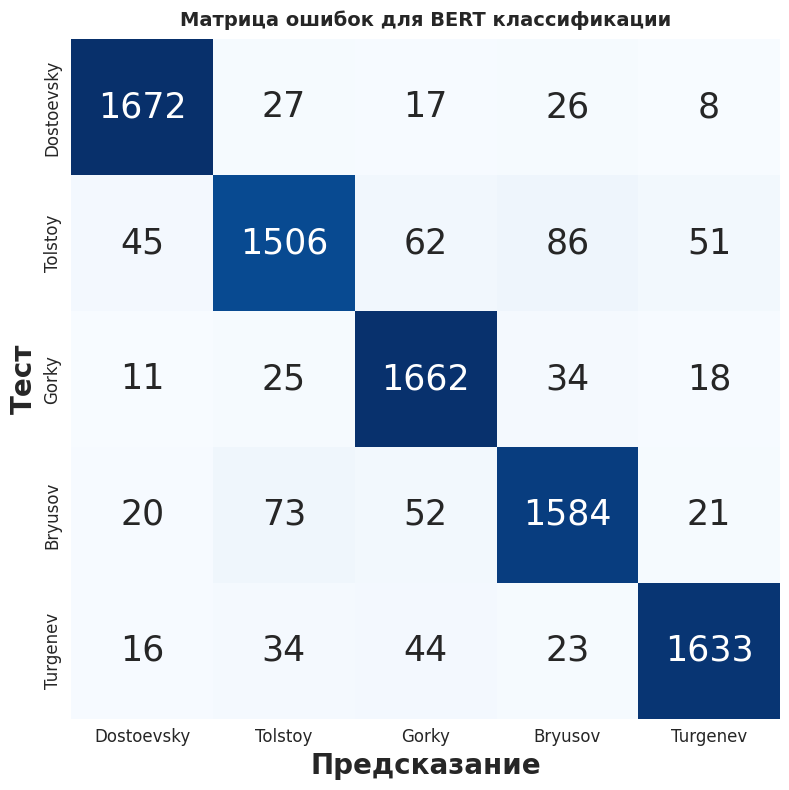

In [ ]:
conf_matrix(
    y_test.argmax(1),
    y_pred.argmax(1),
    'Матрица ошибок для BERT классификации',
    CLASS_LIST,
)

In [ ]:
print('Расчет метрик для BERT классификатора:')
print()
print(classification_report(y_test, y_pred, target_names=CLASS_LIST))


Расчет метрик для BERT классификатора:

              precision    recall  f1-score   support

  Dostoevsky       0.95      0.96      0.95      1750
     Tolstoy       0.90      0.86      0.88      1750
       Gorky       0.90      0.95      0.93      1750
     Bryusov       0.90      0.91      0.90      1750
    Turgenev       0.94      0.93      0.94      1750

   micro avg       0.92      0.92      0.92      8750
   macro avg       0.92      0.92      0.92      8750
weighted avg       0.92      0.92      0.92      8750
 samples avg       0.92      0.92      0.92      8750



#### Дообучение

In [ ]:
# судя по изменениям val_loss, потенциал обучения еще не исчерпан - попробуем дообучить
EPOCHS = 4
BATCH_SIZE = 64


history = model.fit(
    [
        train_input_ids,
        train_attention_masks
    ],
    y_train,
    validation_data=(
        [
            val_input_ids,
            val_attention_masks
        ],
        y_val
    ),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


Epoch 1/4
1094/1094 [==============================] - 144s 132ms/step - loss: 0.0663 - categorical_accuracy: 0.9779 - val_loss: 0.3098 - val_categorical_accuracy: 0.9199
Epoch 2/4
1094/1094 [==============================] - 142s 129ms/step - loss: 0.0531 - categorical_accuracy: 0.9826 - val_loss: 0.2926 - val_categorical_accuracy: 0.9257
Epoch 3/4
1094/1094 [==============================] - 136s 125ms/step - loss: 0.0407 - categorical_accuracy: 0.9870 - val_loss: 0.3082 - val_categorical_accuracy: 0.9232
Epoch 4/4
1094/1094 [==============================] - 141s 129ms/step - loss: 0.0344 - categorical_accuracy: 0.9887 - val_loss: 0.3145 - val_categorical_accuracy: 0.9259


#### Оценка на тестовой выборке после дообучения

In [ ]:
result = model.predict([test_input_ids, test_attention_masks])

274/274 [==============================] - 7s 26ms/step


In [ ]:
y_pred =  np.zeros_like(result)
y_pred[np.arange(len(y_pred)), result.argmax(1)] = 1

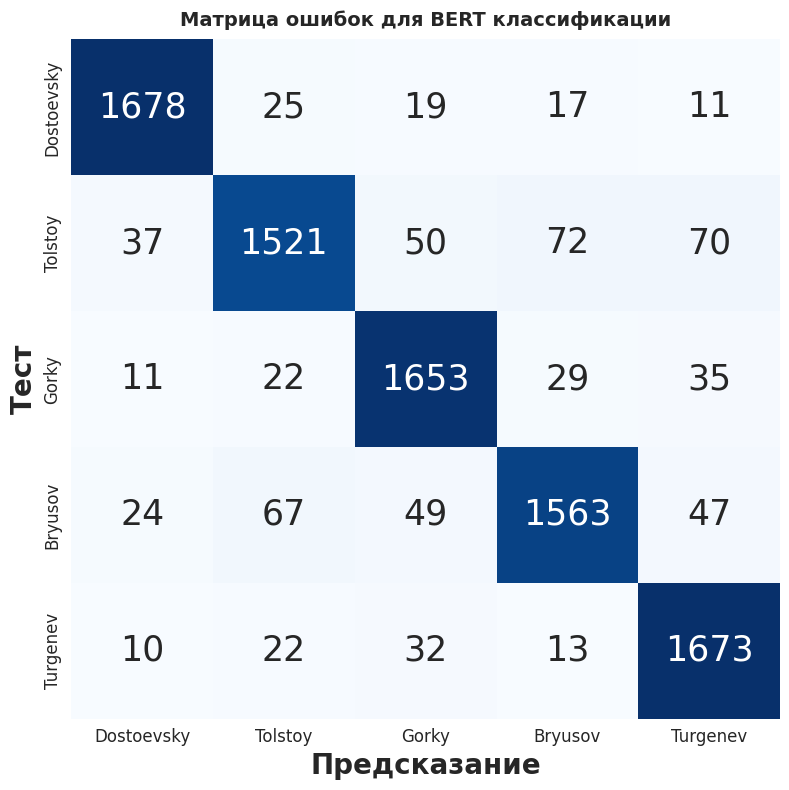

In [ ]:
conf_matrix(
    y_test.argmax(1),
    y_pred.argmax(1),
    'Матрица ошибок для BERT классификации',
    CLASS_LIST,
)

In [ ]:
print('Расчет метрик для BERT классификатора:')
print()
print(classification_report(y_test, y_pred, target_names=CLASS_LIST))


Расчет метрик для BERT классификатора:

              precision    recall  f1-score   support

  Dostoevsky       0.95      0.96      0.96      1750
     Tolstoy       0.92      0.87      0.89      1750
       Gorky       0.92      0.94      0.93      1750
     Bryusov       0.92      0.89      0.91      1750
    Turgenev       0.91      0.96      0.93      1750

   micro avg       0.92      0.92      0.92      8750
   macro avg       0.92      0.92      0.92      8750
weighted avg       0.92      0.92      0.92      8750
 samples avg       0.92      0.92      0.92      8750

